# Current working stack for setting up PEST interface

In [53]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

### load the existing model just to see what is going on

In [54]:
nam_file = "freyberg.nam"
org_model_ws = "freyberg_sfr_update"
m = flopy.modflow.Modflow.load(nam_file,model_ws=org_model_ws,check=False)

In [55]:
m.dis.nper #stress periods

3

wrote shape.shp
No CRS information for writing a .prj file.
Supply an epsg code or .prj file path to the model spatial reference or .export() method.


'shape.shp'

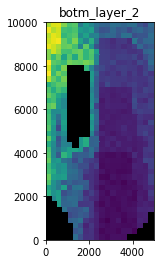

In [57]:
m.dis.botm[2].plot()
m.export("shape.shp")

### change the working dir and write a new copy of model files to keep the others safe

In [58]:
m.change_model_ws("temp",reset_external=True)
m.external_path = '.'
m.exe_name="mfnwt"
m.write_input()
m.run_model()


changing model workspace...
   temp
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:hk: resetting 'h

(True, [])

### build up args for which properties and outputs we want to include in the interface

In [59]:
props,hds = [],[]
for k in range(m.nlay):
    props.append(["upw.hk",k])
    props.append(["upw.vka",k])
    for kper in range(m.nper):
        hds.append([kper,k])
    
props.append(["rch.rech",0])
props.append(["rch.rech",1])
props

[['upw.hk', 0],
 ['upw.vka', 0],
 ['upw.hk', 1],
 ['upw.vka', 1],
 ['upw.hk', 2],
 ['upw.vka', 2],
 ['rch.rech', 0],
 ['rch.rech', 1]]

### Here's where the cool stuff happens: this call will build a pest interace entirely using mulitplier parameters - a mixture of uniform (constant) and grid-scale parameters for all props listed above, plus multipliers for all wells in all stress periods and SFR components.  

### For observations, we will get the MODFLOW list file budget values, sfr outputs and headsave file array values (all of them!).  All observations will be given simulated outputs - this is very useful for error checking...

### The interface package will be written to "template" and includes a python forward run script - "template" is the whole package....

In [60]:
ph = pyemu.helpers.PstFromFlopyModel(nam_file,org_model_ws="temp",
                                     new_model_ws="template",grid_props=props,pp_space=3,
                                    const_props=props,all_wells=True,
                                    sfr_pars=True,hds_kperk=hds,
                                    remove_existing=True, sfr_obs=True,
                                    model_exe_name="mfnwt",build_prior=False)

2018-03-23 11:30:12.631435 starting: loading flopy model

Creating new model with name: freyberg
--------------------------------------------------

Parsing the namefile --> temp/freyberg.nam
Setting filehandles:

--------------------------------------------------
External unit dictionary:
{32: filename:temp/freyberg.nwt, filetype:NWT, 51: filename:temp/freyberg.hds, filetype:DATA(BINARY), 2: filename:temp/freyberg.list, filetype:LIST, 11: filename:temp/freyberg.dis, filetype:DIS, 13: filename:temp/freyberg.bas, filetype:BAS6, 14: filename:temp/freyberg.oc, filetype:OC, 17: filename:temp/freyberg.sfr, filetype:SFR, 50: filename:temp/freyberg.cbc, filetype:DATA(BINARY), 19: filename:temp/freyberg.rch, filetype:RCH, 20: filename:temp/freyberg.wel, filetype:WEL, 60: filename:temp/freyberg.sfr.out, filetype:DATA, 30: filename:temp/freyberg.lmt6, filetype:LMT6, 31: filename:temp/freyberg.upw, filetype:UPW}
--------------------------------------------------

ModflowBas6 free format:True

loa

2018-03-23 11:30:13.048761 finished: writing const tpl:vka3.dat_cn.tpl took: 0:00:00.003549
2018-03-23 11:30:13.051005 starting: writing const tpl:hk4.dat_cn.tpl
2018-03-23 11:30:13.055200 finished: writing const tpl:hk4.dat_cn.tpl took: 0:00:00.004195
2018-03-23 11:30:13.057436 starting: writing const tpl:vka4.dat_cn.tpl
2018-03-23 11:30:13.062112 finished: writing const tpl:vka4.dat_cn.tpl took: 0:00:00.004676
2018-03-23 11:30:13.064940 starting: writing const tpl:hk5.dat_cn.tpl
2018-03-23 11:30:13.068832 finished: writing const tpl:hk5.dat_cn.tpl took: 0:00:00.003892
2018-03-23 11:30:13.071275 starting: writing const tpl:vka5.dat_cn.tpl
2018-03-23 11:30:13.075189 finished: writing const tpl:vka5.dat_cn.tpl took: 0:00:00.003914
2018-03-23 11:30:13.077853 starting: writing const tpl:rech2.dat_cn.tpl
2018-03-23 11:30:13.081643 finished: writing const tpl:rech2.dat_cn.tpl took: 0:00:00.003790
2018-03-23 11:30:13.084020 starting: writing const tpl:rech3.dat_cn.tpl
2018-03-23 11:30:13.088

### let's inspect what just happened...

In [61]:
pst = ph.pst

In [62]:
pst.npar,pst.nobs

(5626, 6633)

# WAT!

In [63]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hcond1_0001,hcond1_0001,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0002,hcond1_0002,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0003,hcond1_0003,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0004,hcond1_0004,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1
hcond1_0005,hcond1_0005,log,factor,1.0,0.01,100.0,hcond1,1.0,0.0,1


In [64]:
pst.observation_data.tail() # the last few observations

,obsnme,obsval,weight,obgnme
vol_total_19700701,vol_total_19700701,2.656250e+01,1.0,vol_total
vol_total_19800628,vol_total_19800628,-1.035000e+04,1.0,vol_total
vol_wells_19700102,vol_wells_19700102,-1.902000e+03,1.0,vol_wells
vol_wells_19700701,vol_wells_19700701,-4.298520e+05,1.0,vol_wells
vol_wells_19800628,vol_wells_19800628,-9.107727e+06,1.0,vol_wells


### write parameter and observtion summary LaTeX tables

In [65]:
pst.write_par_summary_table()
pst.write_obs_summary_table()

### plot the prior distribution of the parameter implied by the parameter bounds (assuming bounds represent 95% credible limits)

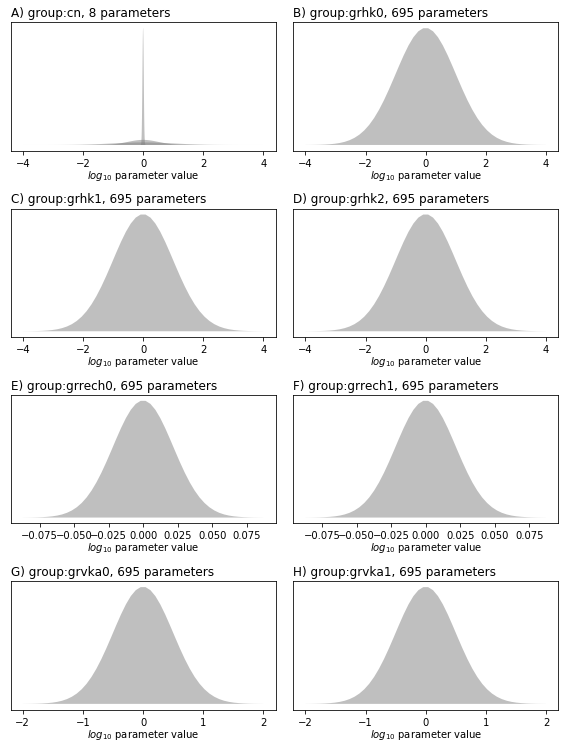

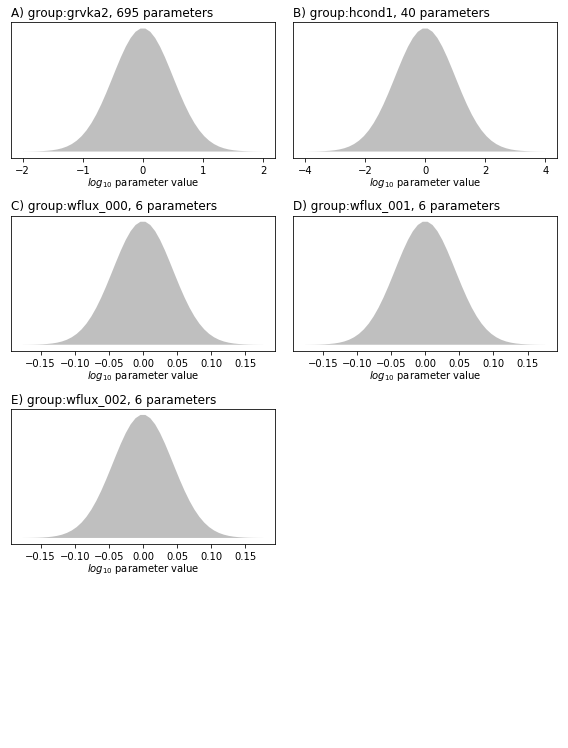

In [66]:
figs = pst.plot(kind="prior",unique_only=True,echo=False)

### but we can do better! We can use geostatistics to build a prior parameter covariance matrix for spatially distributed parameters...

In [67]:
cov = ph.build_prior(fmt="none")

2018-03-23 11:31:49.064653 starting: building prior covariance matrix
building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

build cov matrix
done
getting diag var cov 695
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 695
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 695
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 695
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 695
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 695
scaling f

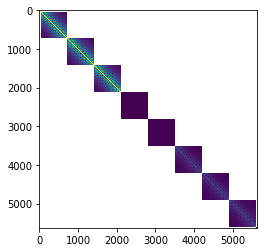

In [68]:
plt.imshow(np.ma.masked_where(cov.x==0,cov.x))
plt.show()

### Let's run pestpp once to get residuals...which should be *nearly* zero since all observations are set to current simulated outputs and all parameters are multipliers - this is a good check!

In [69]:
pyemu.helpers.run("pestpp freyberg.pst",cwd="template")

Reload the pst instance to update the residuals

In [70]:
pst = pyemu.Pst(os.path.join("template","freyberg.pst"))

In [71]:
pst.phi_components

{'flaqx': 0.0,
 'flout': 0.0,
 'flx_constan': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 3.9999999797999994e-10,
 'flx_total': 9.160000023873599e-14,
 'flx_wells': 0.0,
 'hds': 5.262056796372169e-16,
 'vol_constan': 0.00161599999367048,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0017999999998560001,
 'vol_stream_': 0.04039999998078,
 'vol_total': 0.0,
 'vol_wells': 0.0}

### all residuals are *nearly* zero - this is good!

2018-03-23 11:32:24.331832 starting: opening plot_pst_helper.log for logging
2018-03-23 11:32:24.332082 plot_utils.pst_helper()
2018-03-23 11:32:24.332346 starting: plot res_phi_pie
2018-03-23 11:32:26.291548 finished: plot res_phi_pie took: 0:00:01.959202


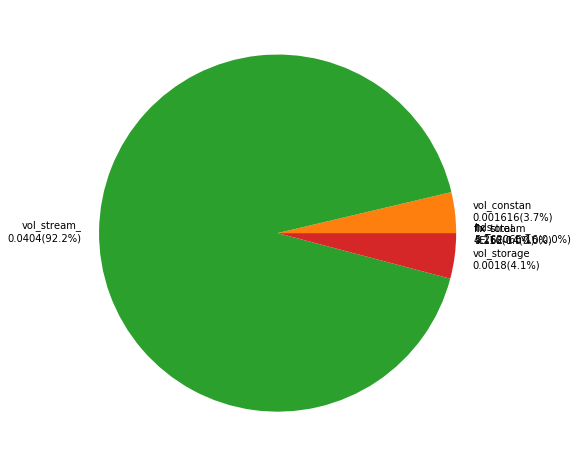

In [72]:
pst.plot(kind='phi_pie')

### Let's do some Monte Carlo!

Generate a parameter ensemble and run it in parallel

In [73]:
pe = pyemu.ParameterEnsemble.from_gaussian_draw(pst=ph.pst,num_reals=100,
                                               cov=cov,use_homegrown=True,
                                                group_chunks=True)

making full cov draws with home-grown goodness
reserving reals matrix
drawing for par group 'hcond1' with 40 pars 
drawing for par group 'grhk0' with 695 pars 
drawing for par group 'grhk1' with 695 pars 
drawing for par group 'grhk2' with 695 pars 
drawing for par group 'cn' with 8 pars 
drawing for par group 'grrech0' with 695 pars 
drawing for par group 'grrech1' with 695 pars 
drawing for par group 'grvka0' with 695 pars 
drawing for par group 'grvka1' with 695 pars 
drawing for par group 'grvka2' with 695 pars 
drawing for par group 'wflux_000' with 6 pars 
drawing for par group 'wflux_001' with 6 pars 
drawing for par group 'wflux_002' with 6 pars 
handling fixed pars


/Users/jeremyw/Dev/pyemu/pyemu/en.py:50: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._mean_values = mean_values


In [74]:
# save to a csv file
pe.to_csv(os.path.join("template","sweep_in.csv"))

In [75]:
# run with sweep using 20 workers
pyemu.helpers.start_slaves("template","sweep","freyberg.pst",num_slaves=20,
                          master_dir="sweep_master")

### more eye candy using the plot helpers...

Every 50th parameters

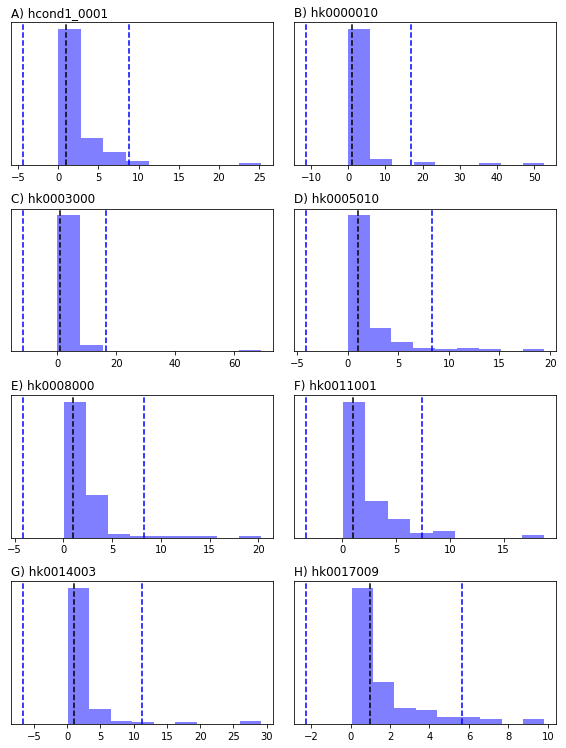

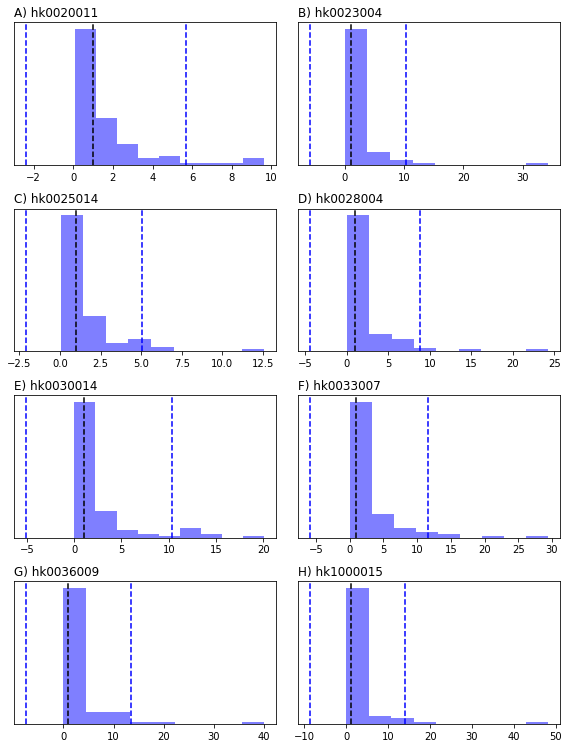

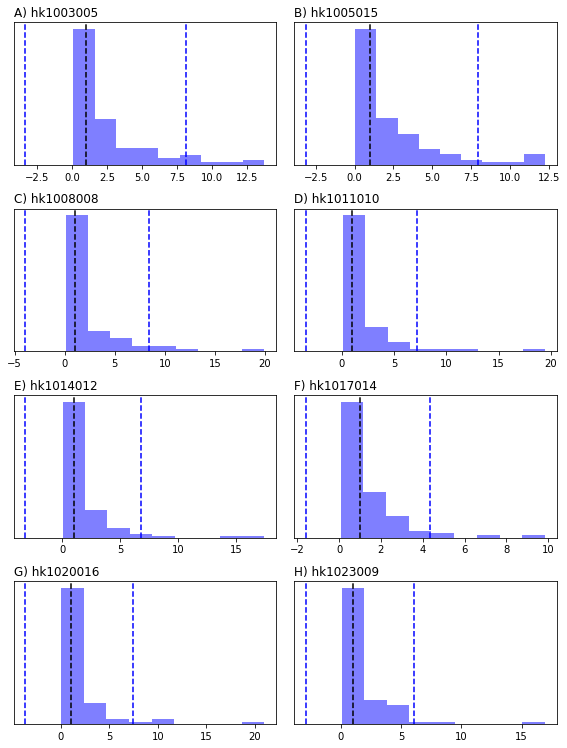

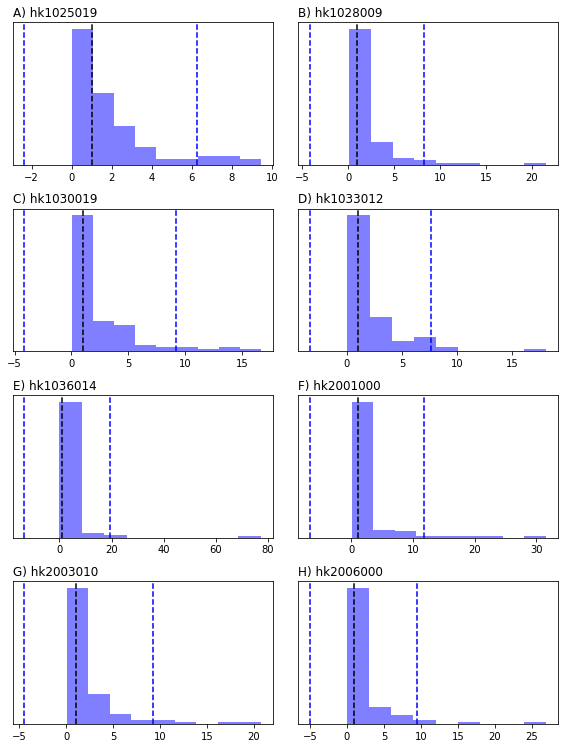

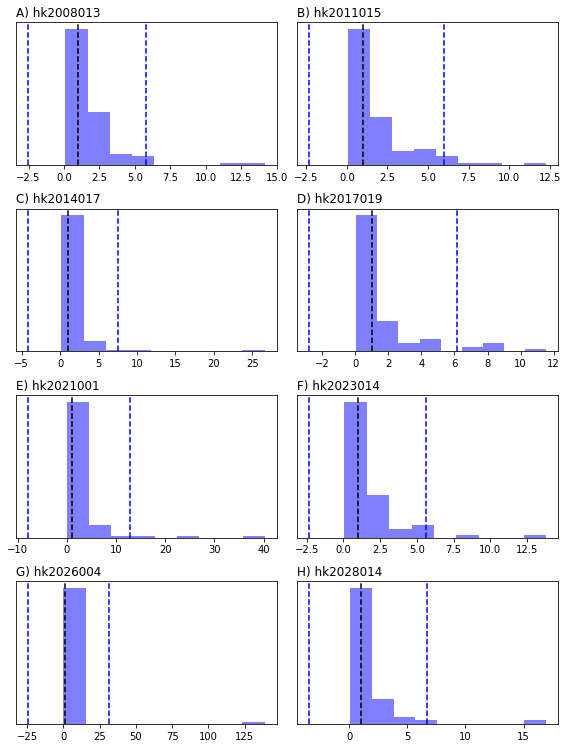

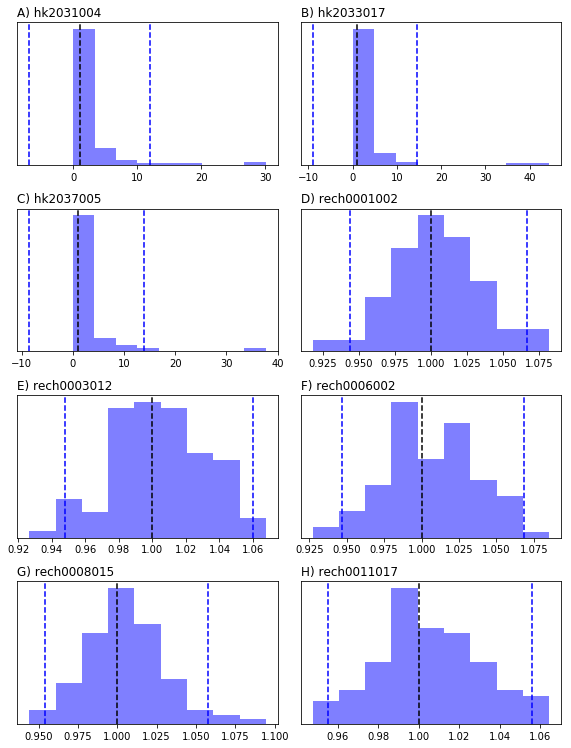

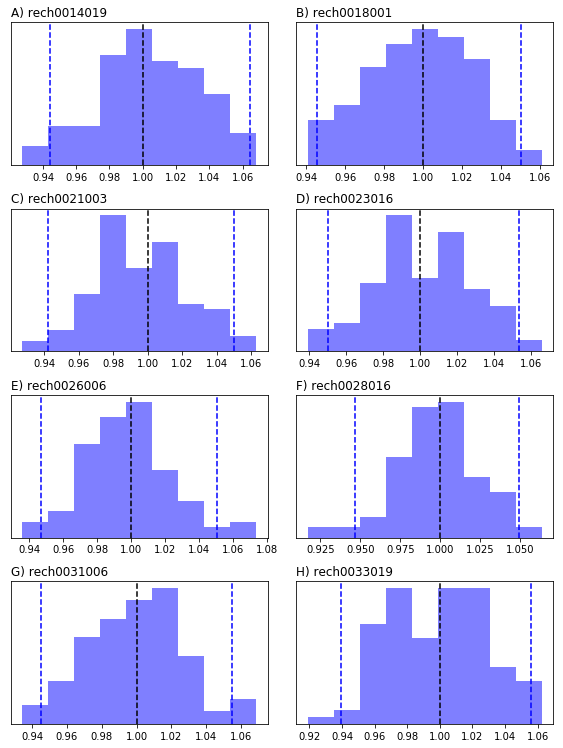

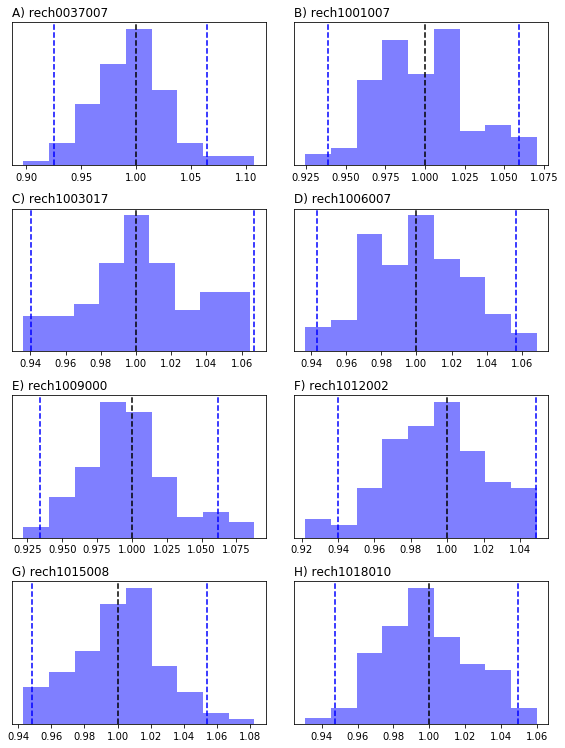

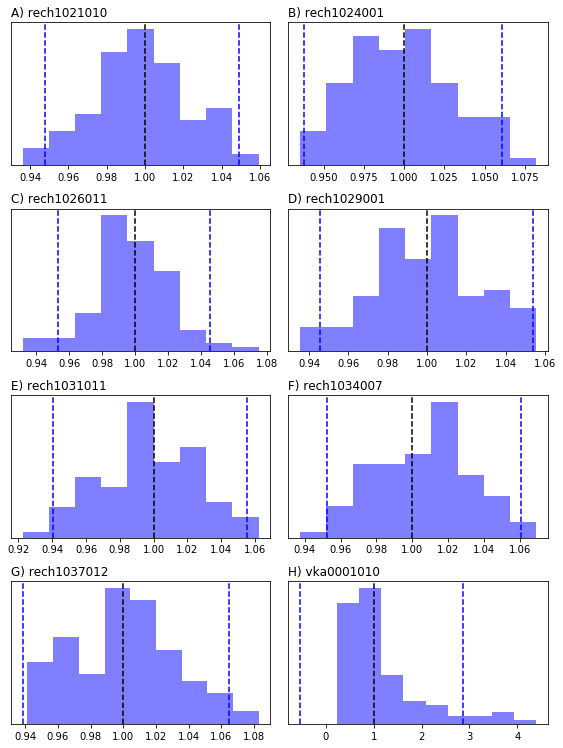

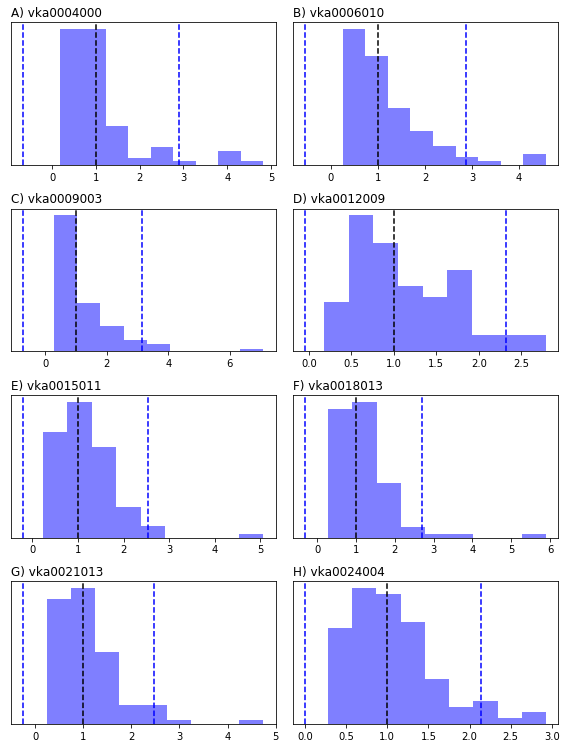

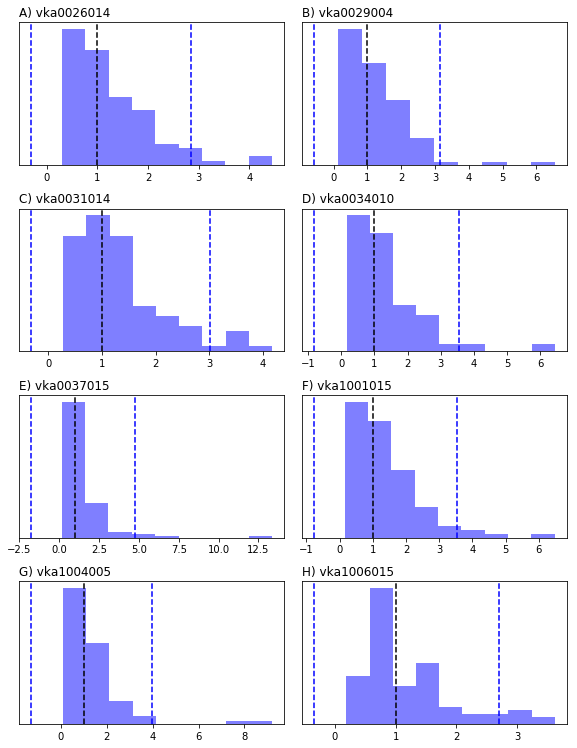

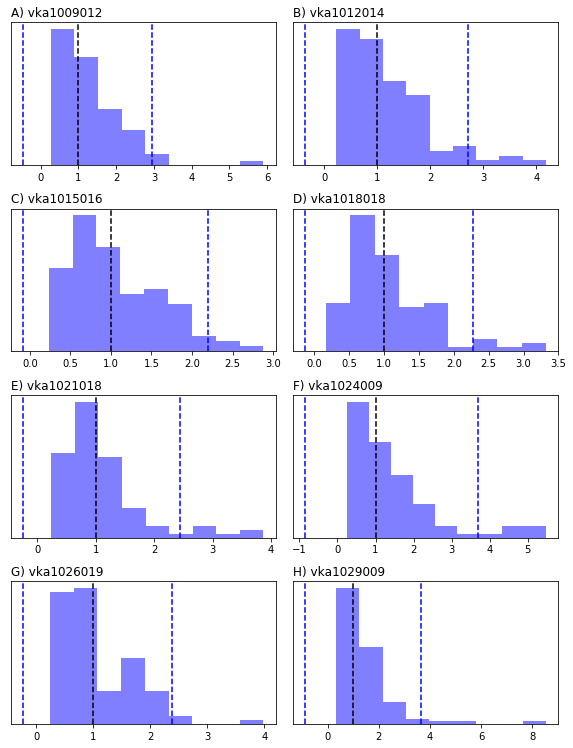

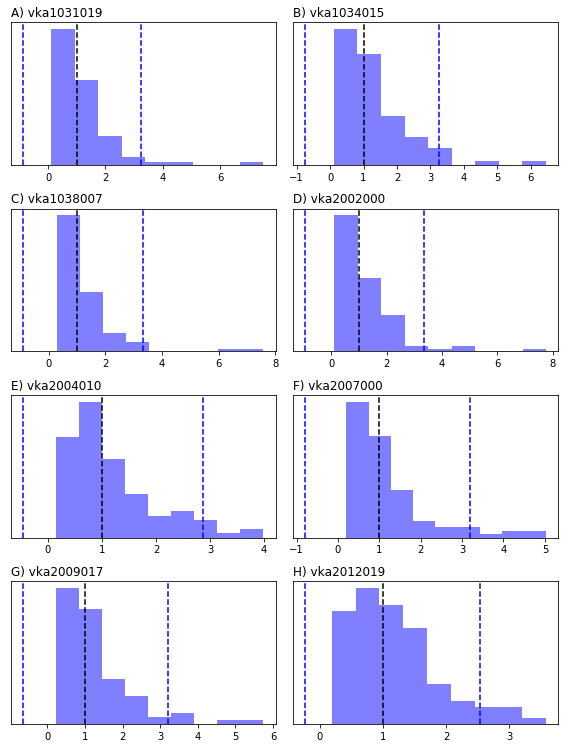

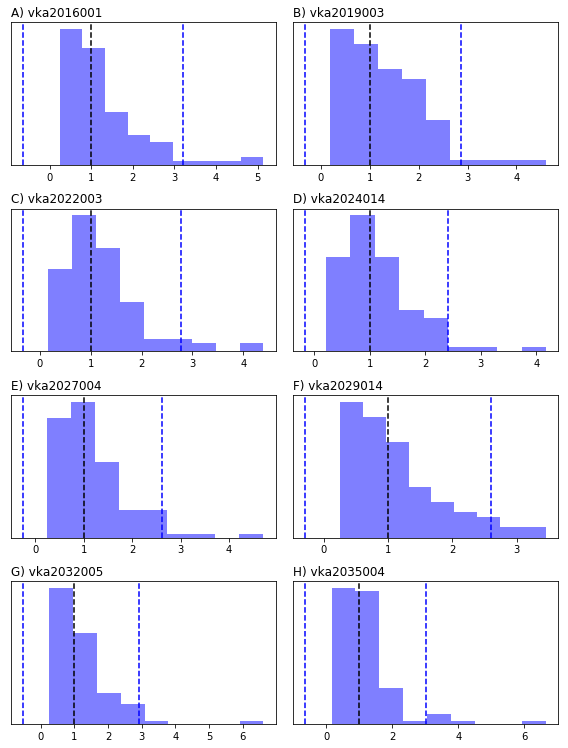

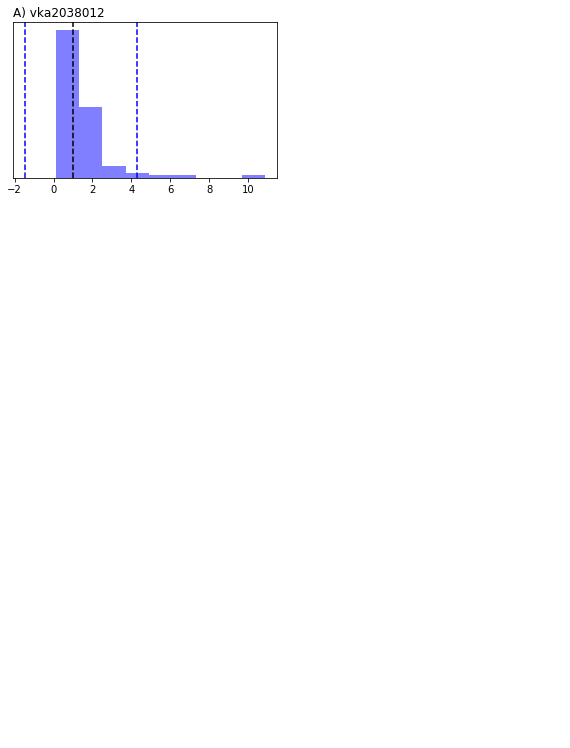

In [28]:
pyemu.plot_utils.ensemble_helper(pe.iloc[:,::50],facecolor='b',
                                 deter_vals=pst.parameter_data.parval1.to_dict(),
                                 filename=None) # you can also pass pdf filename

### load the output csv file....

In [29]:
df = pd.read_csv(os.path.join("sweep_master","sweep_out.csv"))
df.columns = df.columns.map(str.lower)
df = df.loc[:,[o for o in pst.obs_names if "hds_00" in o ]]

### and plot...

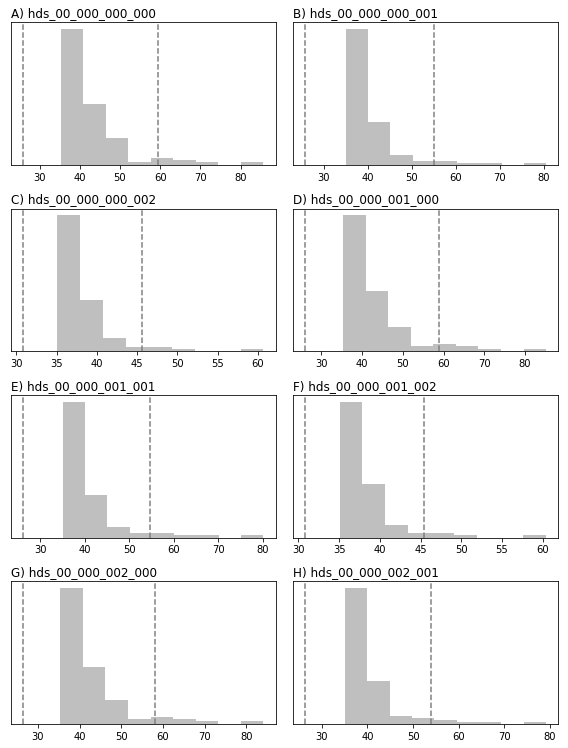

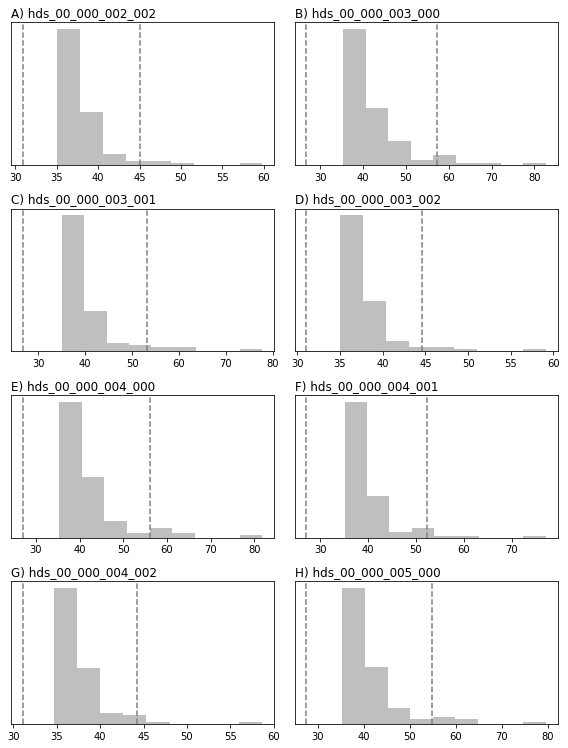

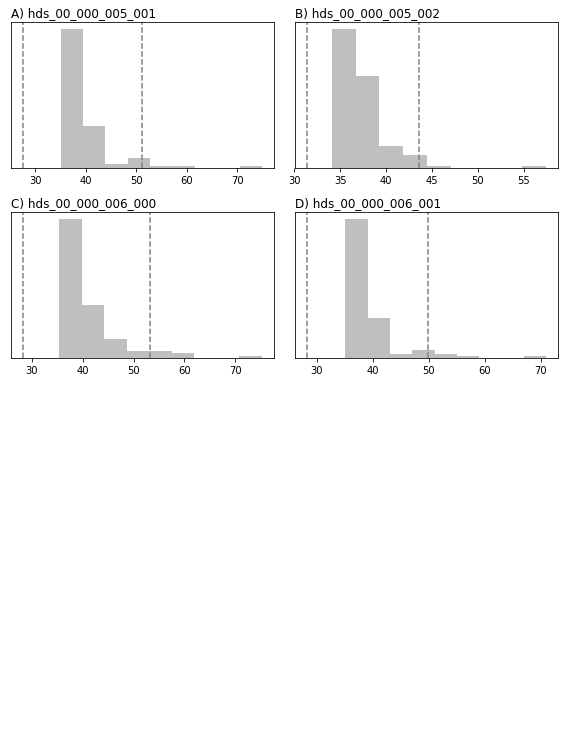

In [30]:
pyemu.plot_utils.ensemble_helper(df.iloc[:,:20],filename=None)